In [22]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline

DATA_ROOT = Path("D:\\rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("D:\\rfcx-species-audio-detection\\train\\")
TEST_AUDIO_ROOT = Path("D:\\rfcx-species-audio-detection\\test\\")

df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT.joinpath('0_raw')).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT.joinpath('0_raw')).glob("*.flac")],
})

df_tp=pd.read_csv(DATA_ROOT.joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(DATA_ROOT.joinpath('train_fp.csv')).set_index('recording_id')


In [3]:
a='TRAIN_CLIP'
'TRAIN' in a

True

In [27]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    
def load_audio(pnfn="", sr=48000):
    y, _ = lb.load(pnfn,
        sr=sr, 
    )
    return y

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, hop_length=params.hop_length,n_fft=params.n_fft
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec


def make_box(df_tp,recording):
    t_start=df_tp['t_min'][recording]
    t_stop= df_tp['t_max'][recording]
    f_min= df_tp['f_min'][recording]
    f_max= df_tp['f_max'][recording]
    #matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
    width=t_stop-t_start
    height=f_max-f_min
    xy=(t_start,f_min)
    return t_start, t_stop, f_min, f_max

def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def subtract_median(med,melspec):
    med_sub=np.zeros(melspec.shape)
    for i,col in enumerate(melspec.transpose()):
        med_sub[:,i]=col-med 
    return med_sub


def save_spectrum_image(y,params):
    fs=params.sr
    ax=params.ax
    use_root=params.use_root
    melspec = compute_melspec(y, params) #Calculate full spectrogram
    med=np.median(melspec,axis=1) #Take median of full spectrogram
    if params.clip_method == 6: #Particularly for TEST set --> make into smaller clips
        #Make a folder for each recording:
        dest=params.use_root.joinpath(params.fn)
        if dest.exists()==False:
            os.mkdir(dest)
            
        # Make 10 6s clips:
        for c,i in enumerate(range(0,60,6)):
            t_min=i
            t_max=i+6
            y_short=y[round(t_min*fs) : round(t_max*fs -1)]
            melspec=compute_melspec(y_short,params)
            params.melspec=subtract_median(med,melspec)
            img_fn='%s_%d.png' % (params.fn,c)
            params.img_pnfn=dest.joinpath(img_fn)
            plot_and_save(params)
    else:
        if 'TRAIN' in params.mode:                      
            if params.clip==True: 
                t_min=params.t_min
                t_max=params.t_max
                y=y[round(t_min*fs) : round(t_max*fs)] #Clip suggested time range                  
                melspec = compute_melspec(y, params) 
                melspec = subtract_median(med,melspec) #Now subtract full spec median from clip or full spec
                if params.keep_med==True: #
                    #Scale median to current colormap range:
                    max_med=np.max(melspec)
                    mm=-1*med
                    mm[mm<0]=0
                    mm=mm-np.min(mm)
                    mm=mm/np.max(mm)
                    mm=mm*np.max(melspec)
                    
                    #Concatenate median with spectrogram
                    melspec=np.column_stack((melspec,mm))
                melspec[melspec < 0]=0
#                 melspec=np.log(melspec)
#                 melspec[melspec < 0]=0
                params.melspec= melspec
                img_fn='%s_%d_%s.png' % (params.type,params.spec,params.fn)
            else:
                melspec = subtract_median(med,melspec) #Now subtract full spec median from clip or full spec
                if params.keep_med==True: #
                    #Scale median to current colormap range:
                    max_med=np.max(melspec)
                    mm=-1*med
                    mm[mm<0]=0
                    mm=mm-np.min(mm)
                    mm=mm/np.max(mm)
                    mm=mm*np.max(melspec)
                    
                    #Concatenate median with spectrogram
                    melspec=np.column_stack((melspec,mm))
                melspec[melspec < 0]=0
#                 melspec=np.log(melspec)
#                 melspec[melspec < 0]=0
                params.melspec= melspec
                img_fn='%s_%d_%s_full.png' % (params.type,params.spec,params.fn)
        elif 'TEST' in params.mode:
            melspec = subtract_median(med,melspec) #Now subtract full spec median from clip or full spec
            if params.keep_med==True: #
                #Scale median to current colormap range:
                max_med=np.max(melspec)
                mm=-1*med
                mm[mm<0]=0
                mm=mm-np.min(mm)
                mm=mm/np.max(mm)
                mm=mm*np.max(melspec)

                #Concatenate median with spectrogram
                melspec=np.column_stack((melspec,mm))
            melspec[melspec < 0]=0
#             melspec=np.log(melspec)
#             melspec[melspec < 0]=0
            params.melspec= melspec
            img_fn='%s.png' % (params.fn)
        
        params.img_pnfn=params.use_root.joinpath(params.dest).joinpath(img_fn)
        plot_and_save(params)

def plot_and_save(params):
        melspec=params.melspec
        img = librosa.display.specshow(
            melspec, 
            sr=params.sr,
            x_axis='time', 
            y_axis='linear', 
            hop_length=params.hop_length,
            cmap='bwr',
            ax=ax)
        #ax.set_ylim((params.fmin,params.fmin))
        ax.axis('off') 
        img_pnfn=params.img_pnfn
        print('\tSaving to %s' % img_pnfn)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(img_pnfn,pad_inches=0,bbox_inches='tight', transparent=True) # <- currently saving a lot of wasted space!!
        time.sleep(0.1)
        plt.cla()


0 of 4727
	 Melspec...

1 of 4727
	 Melspec...

2 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\003bec244.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_003bec244.png

3 of 4727
	 Melspec...

4 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\006ab765f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_006ab765f.png

5 of 4727
	 Melspec...

6 of 4727
	 Melspec...

7 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\007f87ba2.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_007f87ba2.png

8 of 4727
	 Melspec...

9 of 4727
	 Melspec...

10 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\0099c367b.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_0099c367b.png

11 of 4727
	 Melspec...

12 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\009b760e6.flac
	Saving to D:\rfc


119 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\068f1b8e2.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_068f1b8e2.png

120 of 4727
	 Melspec...

121 of 4727
	 Melspec...

122 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\06a0c48c9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_06a0c48c9.png

123 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\06c44d203.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_06c44d203.png

124 of 4727
	 Melspec...

125 of 4727
	 Melspec...

126 of 4727
	 Melspec...

127 of 4727
	 Melspec...

128 of 4727
	 Melspec...

129 of 4727
	 Melspec...

130 of 4727
	 Melspec...

131 of 4727
	 Melspec...

132 of 4727
	 Melspec...

133 of 4727
	 Melspec...

134 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\073e4d908.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_0e799da44.png

285 of 4727
	 Melspec...

286 of 4727
	 Melspec...

287 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\0ea8ea68a.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_0ea8ea68a.png

288 of 4727
	 Melspec...

289 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\0eb2079ea.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_0eb2079ea.png

290 of 4727
	 Melspec...

291 of 4727
	 Melspec...

292 of 4727
	 Melspec...

293 of 4727
	 Melspec...

294 of 4727
	 Melspec...

295 of 4727
	 Melspec...

296 of 4727
	 Melspec...

297 of 4727
	 Melspec...

298 of 4727
	 Melspec...

299 of 4727
	 Melspec...

300 of 4727
	 Melspec...

301 of 4727
	 Melspec...

302 of 4727
	 Melspec...

303 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\0f8cadb4a.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_1535d0c9b.png

416 of 4727
	 Melspec...

417 of 4727
	 Melspec...

418 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\1545e29b3.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_1545e29b3.png

419 of 4727
	 Melspec...

420 of 4727
	 Melspec...

421 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\156b77dfe.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_156b77dfe.png

422 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\157a50231.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_157a50231.png

423 of 4727
	 Melspec...

424 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\158c5acb6.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_16_158c5acb6.png

425 of 4727
	 Melspec...

426 of 4727
	 Melspec...

427 of 4727
	 Melspec...
	Loading 


540 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\1b77382c7.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_1b77382c7.png

541 of 4727
	 Melspec...

542 of 4727
	 Melspec...

543 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\1ba9ee79a.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_1ba9ee79a.png

544 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\1bc8c196e.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_22_1bc8c196e.png

545 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\1bd29a4bb.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_10_1bd29a4bb.png

546 of 4727
	 Melspec...

547 of 4727
	 Melspec...

548 of 4727
	 Melspec...

549 of 4727
	 Melspec...

550 of 4727
	 Melspec...

551 of 4727
	 Melspec...

552 of 4727
	 Melspec...

553 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detect

668 of 4727
	 Melspec...

669 of 4727
	 Melspec...

670 of 4727
	 Melspec...

671 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\226ce47d9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_226ce47d9.png

672 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\22a2faf44.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_13_22a2faf44.png

673 of 4727
	 Melspec...

674 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\22b46c334.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_8_22b46c334.png

675 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\22bfc5978.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_22bfc5978.png

676 of 4727
	 Melspec...

677 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\22da462f9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_22da462f


788 of 4727
	 Melspec...

789 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\29b82a129.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_29b82a129.png

790 of 4727
	 Melspec...

791 of 4727
	 Melspec...

792 of 4727
	 Melspec...

793 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\2a1bb0557.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_2a1bb0557.png

794 of 4727
	 Melspec...

795 of 4727
	 Melspec...

796 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\2a3c1f921.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_2a3c1f921.png

797 of 4727
	 Melspec...

798 of 4727
	 Melspec...

799 of 4727
	 Melspec...

800 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\2a69408f6.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_2a69408f6.png

801 of 4727
	 Melspec...

802 of 4727
	 Melspec...

803 of 4727

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_2fc2eca0c.png

902 of 4727
	 Melspec...

903 of 4727
	 Melspec...

904 of 4727
	 Melspec...

905 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\2febbdfc5.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_15_2febbdfc5.png

906 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\2ffaa6c02.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_15_2ffaa6c02.png

907 of 4727
	 Melspec...

908 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\304141997.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_304141997.png

909 of 4727
	 Melspec...

910 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\304b4b5fd.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_304b4b5fd.png

911 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\3051fc9

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_3710abba6.png

1026 of 4727
	 Melspec...

1027 of 4727
	 Melspec...

1028 of 4727
	 Melspec...

1029 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\373f470c4.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_373f470c4.png

1030 of 4727
	 Melspec...

1031 of 4727
	 Melspec...

1032 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\376a0a779.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_376a0a779.png

1033 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\377e04f82.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_377e04f82.png

1034 of 4727
	 Melspec...

1035 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\37b6d1db9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_37b6d1db9.png

1036 of 4727
	 Melspec...

1037 of 4727
	 Melspe


1160 of 4727
	 Melspec...

1161 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\3fa666880.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_22_3fa666880.png

1162 of 4727
	 Melspec...

1163 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\3fcca1372.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_3fcca1372.png

1164 of 4727
	 Melspec...

1165 of 4727
	 Melspec...

1166 of 4727
	 Melspec...

1167 of 4727
	 Melspec...

1168 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\3ffaeaa6c.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_15_3ffaeaa6c.png

1169 of 4727
	 Melspec...

1170 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\400b7210c.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_400b7210c.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_400b7210c.png
	Saving to D:\rfcx-sp

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_4696db75c.png

1289 of 4727
	 Melspec...

1290 of 4727
	 Melspec...

1291 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\46c7db806.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_46c7db806.png

1292 of 4727
	 Melspec...

1293 of 4727
	 Melspec...

1294 of 4727
	 Melspec...

1295 of 4727
	 Melspec...

1296 of 4727
	 Melspec...

1297 of 4727
	 Melspec...

1298 of 4727
	 Melspec...

1299 of 4727
	 Melspec...

1300 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\471bb3a84.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_471bb3a84.png

1301 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\471df4911.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_471df4911.png

1302 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\473cac467.flac
	Saving to D:\rfcx-spe


1427 of 4727
	 Melspec...

1428 of 4727
	 Melspec...

1429 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\4df50c66e.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_4df50c66e.png

1430 of 4727
	 Melspec...

1431 of 4727
	 Melspec...

1432 of 4727
	 Melspec...

1433 of 4727
	 Melspec...

1434 of 4727
	 Melspec...

1435 of 4727
	 Melspec...

1436 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\4e2898673.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_4e2898673.png

1437 of 4727
	 Melspec...

1438 of 4727
	 Melspec...

1439 of 4727
	 Melspec...

1440 of 4727
	 Melspec...

1441 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\4e464ff6b.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_6_4e464ff6b.png

1442 of 4727
	 Melspec...

1443 of 4727
	 Melspec...

1444 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\4e4bc17a7.fla

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_551385b05.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_551385b05.png

1566 of 4727
	 Melspec...

1567 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\55228e5c5.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_16_55228e5c5.png

1568 of 4727
	 Melspec...

1569 of 4727
	 Melspec...

1570 of 4727
	 Melspec...

1571 of 4727
	 Melspec...

1572 of 4727
	 Melspec...

1573 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\55648ef63.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_55648ef63.png

1574 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\556cb3c93.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_556cb3c93.png

1575 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\557506b62.flac
	Saving to D:\rfcx-species-audio-detection\train


1663 of 4727
	 Melspec...

1664 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\59ce91d00.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_16_59ce91d00.png

1665 of 4727
	 Melspec...

1666 of 4727
	 Melspec...

1667 of 4727
	 Melspec...

1668 of 4727
	 Melspec...

1669 of 4727
	 Melspec...

1670 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\59e549ee2.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_59e549ee2.png

1671 of 4727
	 Melspec...

1672 of 4727
	 Melspec...

1673 of 4727
	 Melspec...

1674 of 4727
	 Melspec...

1675 of 4727
	 Melspec...

1676 of 4727
	 Melspec...

1677 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\5a2185b19.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_20_5a2185b19.png

1678 of 4727
	 Melspec...

1679 of 4727
	 Melspec...

1680 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\5a3f09a5c.fl


1785 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\5f9b4785b.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_5f9b4785b.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_15_5f9b4785b.png

1786 of 4727
	 Melspec...

1787 of 4727
	 Melspec...

1788 of 4727
	 Melspec...

1789 of 4727
	 Melspec...

1790 of 4727
	 Melspec...

1791 of 4727
	 Melspec...

1792 of 4727
	 Melspec...

1793 of 4727
	 Melspec...

1794 of 4727
	 Melspec...

1795 of 4727
	 Melspec...

1796 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\604583528.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_604583528.png

1797 of 4727
	 Melspec...

1798 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\606f1e495.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_606f1e495.png

1799 of 4727
	 Melspec...

1800 of 4727
	 Melspec...

1801 of 4727
	 Melspec...
	Loading D:


1927 of 4727
	 Melspec...

1928 of 4727
	 Melspec...

1929 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\67763b1b9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_67763b1b9.png

1930 of 4727
	 Melspec...

1931 of 4727
	 Melspec...

1932 of 4727
	 Melspec...

1933 of 4727
	 Melspec...

1934 of 4727
	 Melspec...

1935 of 4727
	 Melspec...

1936 of 4727
	 Melspec...

1937 of 4727
	 Melspec...

1938 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\682657006.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_13_682657006.png

1939 of 4727
	 Melspec...

1940 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\6838dc4f9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_10_6838dc4f9.png

1941 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\687733bf1.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_687733bf1.

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_7_6eb03e9ca.png

2054 of 4727
	 Melspec...

2055 of 4727
	 Melspec...

2056 of 4727
	 Melspec...

2057 of 4727
	 Melspec...

2058 of 4727
	 Melspec...

2059 of 4727
	 Melspec...

2060 of 4727
	 Melspec...

2061 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\6f7eec323.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_6f7eec323.png

2062 of 4727
	 Melspec...

2063 of 4727
	 Melspec...

2064 of 4727
	 Melspec...

2065 of 4727
	 Melspec...

2066 of 4727
	 Melspec...

2067 of 4727
	 Melspec...

2068 of 4727
	 Melspec...

2069 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\706e6f1e8.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_706e6f1e8.png

2070 of 4727
	 Melspec...

2071 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7080d05d4.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_755d6c7eb.png

2170 of 4727
	 Melspec...

2171 of 4727
	 Melspec...

2172 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7583b7c0c.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_7583b7c0c.png

2173 of 4727
	 Melspec...

2174 of 4727
	 Melspec...

2175 of 4727
	 Melspec...

2176 of 4727
	 Melspec...

2177 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\75c8ccce9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_75c8ccce9.png

2178 of 4727
	 Melspec...

2179 of 4727
	 Melspec...

2180 of 4727
	 Melspec...

2181 of 4727
	 Melspec...

2182 of 4727
	 Melspec...

2183 of 4727
	 Melspec...

2184 of 4727
	 Melspec...

2185 of 4727
	 Melspec...

2186 of 4727
	 Melspec...

2187 of 4727
	 Melspec...

2188 of 4727
	 Melspec...

2189 of 4727
	 Melspec...

2190 of 4727
	 Melspec...

2191 of 4727
	 Melspec...

2192 of 4727
	 Melspec.


2281 of 4727
	 Melspec...

2282 of 4727
	 Melspec...

2283 of 4727
	 Melspec...

2284 of 4727
	 Melspec...

2285 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7ad715d6d.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_7ad715d6d.png

2286 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7ada8c4da.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_7ada8c4da.png

2287 of 4727
	 Melspec...

2288 of 4727
	 Melspec...

2289 of 4727
	 Melspec...

2290 of 4727
	 Melspec...

2291 of 4727
	 Melspec...

2292 of 4727
	 Melspec...

2293 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7b287d190.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_20_7b287d190.png

2294 of 4727
	 Melspec...

2295 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\7b4ee85a5.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_1_7b4ee85a5.p


2418 of 4727
	 Melspec...

2419 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\8253e1640.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_8253e1640.png

2420 of 4727
	 Melspec...

2421 of 4727
	 Melspec...

2422 of 4727
	 Melspec...

2423 of 4727
	 Melspec...

2424 of 4727
	 Melspec...

2425 of 4727
	 Melspec...

2426 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\82a813386.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_82a813386.png

2427 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\82d59d24d.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_22_82d59d24d.png

2428 of 4727
	 Melspec...

2429 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\82ff46226.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_82ff46226.png

2430 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_


2557 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\89fe494b6.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_22_89fe494b6.png

2558 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\8a0ee2e2c.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_8_8a0ee2e2c.png

2559 of 4727
	 Melspec...

2560 of 4727
	 Melspec...

2561 of 4727
	 Melspec...

2562 of 4727
	 Melspec...

2563 of 4727
	 Melspec...

2564 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\8a59b5c31.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_8a59b5c31.png

2565 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\8a63ca713.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_4_8a63ca713.png

2566 of 4727
	 Melspec...

2567 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\8a99905ac.flac
	Saving to D:\rfcx-species-audio-detec


2700 of 4727
	 Melspec...

2701 of 4727
	 Melspec...

2702 of 4727
	 Melspec...

2703 of 4727
	 Melspec...

2704 of 4727
	 Melspec...

2705 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\9251fdbdd.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_16_9251fdbdd.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_16_9251fdbdd.png

2706 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\92588122c.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_92588122c.png

2707 of 4727
	 Melspec...

2708 of 4727
	 Melspec...

2709 of 4727
	 Melspec...

2710 of 4727
	 Melspec...

2711 of 4727
	 Melspec...

2712 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\929d655d3.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_929d655d3.png

2713 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\92ae9bcc2.flac
	Saving to D:\rfcx-spec

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_9a76cab9c.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_9a76cab9c.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_9a76cab9c.png

2855 of 4727
	 Melspec...

2856 of 4727
	 Melspec...

2857 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\9a9951303.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_9a9951303.png

2858 of 4727
	 Melspec...

2859 of 4727
	 Melspec...

2860 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\9abdbfc9f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_9abdbfc9f.png

2861 of 4727
	 Melspec...

2862 of 4727
	 Melspec...

2863 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\9afa17810.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_7_9afa17810.png

2864 of 4727
	 Melspec...

2865 of 4727
	 Melspec...

2866 of


2978 of 4727
	 Melspec...

2979 of 4727
	 Melspec...

2980 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a1b1a5e31.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_a1b1a5e31.png

2981 of 4727
	 Melspec...

2982 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a1d96c821.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_a1d96c821.png

2983 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a1ef2a84f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_a1ef2a84f.png

2984 of 4727
	 Melspec...

2985 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a2045d15d.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_22_a2045d15d.png

2986 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a212bf2e0.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_13_a212bf2e0.png

2987 of

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_a8e6d4d75.png

3111 of 4727
	 Melspec...

3112 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a90c80393.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_a90c80393.png

3113 of 4727
	 Melspec...

3114 of 4727
	 Melspec...

3115 of 4727
	 Melspec...

3116 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a92850ccd.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_2_a92850ccd.png

3117 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a9637eb5b.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_a9637eb5b.png

3118 of 4727
	 Melspec...

3119 of 4727
	 Melspec...

3120 of 4727
	 Melspec...

3121 of 4727
	 Melspec...

3122 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\a9868c3d1.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_a9868c3d1

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_af6a0d203.png

3227 of 4727
	 Melspec...

3228 of 4727
	 Melspec...

3229 of 4727
	 Melspec...

3230 of 4727
	 Melspec...

3231 of 4727
	 Melspec...

3232 of 4727
	 Melspec...

3233 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\afa49cbeb.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_afa49cbeb.png

3234 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\afaa8d38f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_afaa8d38f.png

3235 of 4727
	 Melspec...

3236 of 4727
	 Melspec...

3237 of 4727
	 Melspec...

3238 of 4727
	 Melspec...

3239 of 4727
	 Melspec...

3240 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\b01abd3b2.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_b01abd3b2.png

3241 of 4727
	 Melspec...

3242 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detecti


3366 of 4727
	 Melspec...

3367 of 4727
	 Melspec...

3368 of 4727
	 Melspec...

3369 of 4727
	 Melspec...

3370 of 4727
	 Melspec...

3371 of 4727
	 Melspec...

3372 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\b7485fa88.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_6_b7485fa88.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_b7485fa88.png

3373 of 4727
	 Melspec...

3374 of 4727
	 Melspec...

3375 of 4727
	 Melspec...

3376 of 4727
	 Melspec...

3377 of 4727
	 Melspec...

3378 of 4727
	 Melspec...

3379 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\b7a71d152.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_13_b7a71d152.png

3380 of 4727
	 Melspec...

3381 of 4727
	 Melspec...

3382 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\b7c63f218.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_13_b7c63f218.png

3383 of 4

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_17_bdd4aa62c.png

3488 of 4727
	 Melspec...

3489 of 4727
	 Melspec...

3490 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\be0356cf5.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_be0356cf5.png

3491 of 4727
	 Melspec...

3492 of 4727
	 Melspec...

3493 of 4727
	 Melspec...

3494 of 4727
	 Melspec...

3495 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\be6a8ad0d.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_be6a8ad0d.png

3496 of 4727
	 Melspec...

3497 of 4727
	 Melspec...

3498 of 4727
	 Melspec...

3499 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\bea3bcffa.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_8_bea3bcffa.png

3500 of 4727
	 Melspec...

3501 of 4727
	 Melspec...

3502 of 4727
	 Melspec...

3503 of 4727
	 Melspec...

3504 of 4727
	 Melspec...

3505 of 472


3619 of 4727
	 Melspec...

3620 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\c569b8181.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_c569b8181.png

3621 of 4727
	 Melspec...

3622 of 4727
	 Melspec...

3623 of 4727
	 Melspec...

3624 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\c5758ce2f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_11_c5758ce2f.png

3625 of 4727
	 Melspec...

3626 of 4727
	 Melspec...

3627 of 4727
	 Melspec...

3628 of 4727
	 Melspec...

3629 of 4727
	 Melspec...

3630 of 4727
	 Melspec...

3631 of 4727
	 Melspec...

3632 of 4727
	 Melspec...

3633 of 4727
	 Melspec...

3634 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\c5d61be80.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_4_c5d61be80.png

3635 of 4727
	 Melspec...

3636 of 4727
	 Melspec...

3637 of 4727
	 Melspec...

3638 of 4727
	 Melspec...

3639 of 472

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_cc05ecd08.png

3758 of 4727
	 Melspec...

3759 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\cc2c48fd7.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_3_cc2c48fd7.png

3760 of 4727
	 Melspec...

3761 of 4727
	 Melspec...

3762 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\cc7c17269.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_20_cc7c17269.png

3763 of 4727
	 Melspec...

3764 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\cc8d81b6a.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_cc8d81b6a.png

3765 of 4727
	 Melspec...

3766 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\ccd0a0bff.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_ccd0a0bff.png

3767 of 4727
	 Melspec...

3768 of 4727
	 Melspec...
	Loading D:\rfcx-speci

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_2_d2cb96229.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_2_d2cb96229.png

3877 of 4727
	 Melspec...

3878 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d3020850e.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_d3020850e.png

3879 of 4727
	 Melspec...

3880 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d3195bece.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_10_d3195bece.png

3881 of 4727
	 Melspec...

3882 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d32242280.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_d32242280.png

3883 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d3324f1c0.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_d3324f1c0.png

3884 of 4727
	 Melspec...
	Loading D:\rfcx-speci

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_d8b7f9ed6.png

3989 of 4727
	 Melspec...

3990 of 4727
	 Melspec...

3991 of 4727
	 Melspec...

3992 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d91f25ca7.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_d91f25ca7.png

3993 of 4727
	 Melspec...

3994 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d922d82e9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_d922d82e9.png

3995 of 4727
	 Melspec...

3996 of 4727
	 Melspec...

3997 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\d93aaa1bc.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_18_d93aaa1bc.png

3998 of 4727
	 Melspec...

3999 of 4727
	 Melspec...

4000 of 4727
	 Melspec...

4001 of 4727
	 Melspec...

4002 of 4727
	 Melspec...

4003 of 4727
	 Melspec...

4004 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detec


4105 of 4727
	 Melspec...

4106 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\de80fb815.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_de80fb815.png

4107 of 4727
	 Melspec...

4108 of 4727
	 Melspec...

4109 of 4727
	 Melspec...

4110 of 4727
	 Melspec...

4111 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\dee541308.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_dee541308.png

4112 of 4727
	 Melspec...

4113 of 4727
	 Melspec...

4114 of 4727
	 Melspec...

4115 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\dfa6a4a64.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_10_dfa6a4a64.png

4116 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\dfa80535f.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_10_dfa80535f.png

4117 of 4727
	 Melspec...

4118 of 4727
	 Melspec...

4119 of 4727
	 Melspec


4250 of 4727
	 Melspec...

4251 of 4727
	 Melspec...

4252 of 4727
	 Melspec...

4253 of 4727
	 Melspec...

4254 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\e65e42310.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_e65e42310.png

4255 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\e6622a3c9.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_4_e6622a3c9.png

4256 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\e666beee8.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_9_e666beee8.png

4257 of 4727
	 Melspec...

4258 of 4727
	 Melspec...

4259 of 4727
	 Melspec...

4260 of 4727
	 Melspec...

4261 of 4727
	 Melspec...

4262 of 4727
	 Melspec...

4263 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\e6af91bbf.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_12_e6af91bbf.png

4264 of 4727
	 Melspec.


4363 of 4727
	 Melspec...

4364 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\ec3a54dc6.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_14_ec3a54dc6.png

4365 of 4727
	 Melspec...

4366 of 4727
	 Melspec...

4367 of 4727
	 Melspec...

4368 of 4727
	 Melspec...

4369 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\ec63de3ab.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_5_ec63de3ab.png

4370 of 4727
	 Melspec...

4371 of 4727
	 Melspec...

4372 of 4727
	 Melspec...

4373 of 4727
	 Melspec...

4374 of 4727
	 Melspec...

4375 of 4727
	 Melspec...

4376 of 4727
	 Melspec...

4377 of 4727
	 Melspec...

4378 of 4727
	 Melspec...

4379 of 4727
	 Melspec...

4380 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\ecd47f7cc.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_ecd47f7cc.png

4381 of 4727
	 Melspec...

4382 of 4727
	 Melspec...

4383 of 47

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_f3b84afb1.png

4506 of 4727
	 Melspec...

4507 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\f3cb40395.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_f3cb40395.png

4508 of 4727
	 Melspec...

4509 of 4727
	 Melspec...

4510 of 4727
	 Melspec...

4511 of 4727
	 Melspec...

4512 of 4727
	 Melspec...

4513 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\f3f82b897.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_f3f82b897.png
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_19_f3f82b897.png

4514 of 4727
	 Melspec...

4515 of 4727
	 Melspec...

4516 of 4727
	 Melspec...

4517 of 4727
	 Melspec...

4518 of 4727
	 Melspec...

4519 of 4727
	 Melspec...

4520 of 4727
	 Melspec...

4521 of 4727
	 Melspec...

4522 of 4727
	 Melspec...

4523 of 4727
	 Melspec...

4524 of 4727
	 Melspec...
	Loading D:\rfcx-specie

	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_23_fbd5bbb6e.png

4650 of 4727
	 Melspec...

4651 of 4727
	 Melspec...

4652 of 4727
	 Melspec...

4653 of 4727
	 Melspec...

4654 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\fc47cfba3.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_fc47cfba3.png

4655 of 4727
	 Melspec...

4656 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\fc6609050.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_0_fc6609050.png

4657 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\fc6c3b488.flac
	Saving to D:\rfcx-species-audio-detection\train\tp_clips_med\TP_21_fc6c3b488.png

4658 of 4727
	 Melspec...

4659 of 4727
	 Melspec...

4660 of 4727
	 Melspec...

4661 of 4727
	 Melspec...

4662 of 4727
	 Melspec...

4663 of 4727
	 Melspec...
	Loading D:\rfcx-species-audio-detection\train\0_raw\fd1970634.flac
	Saving to D:\rfcx-speci

TypeError: load_audio() takes from 0 to 2 positional arguments but 3 were given

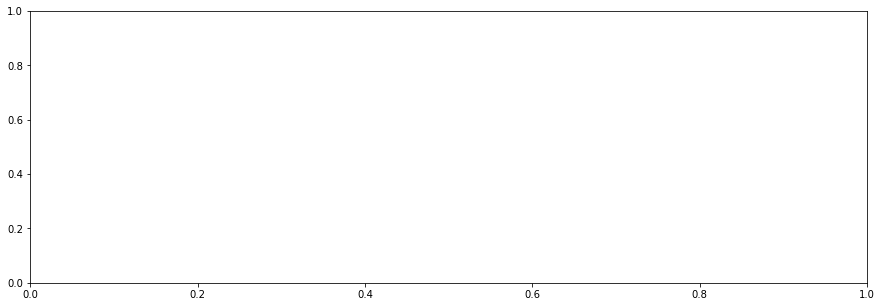

In [28]:
# Make spectrum for each species in recording in train/test:
fig, ax = plt.subplots(figsize=(15, 5))
params.ax=ax
modes = ['TRAIN_CLIP_TP','TRAIN_FULL','TEST_FULL']
params.clip_method=0 # Method 6 = split TEST into 6s chunks
for mode in modes:
    if mode == 'TEST_FULL':
        use_df=df_test
        use_root=TEST_AUDIO_ROOT
        params.clip=False 
        params.dest='full_med'
        params.keep_med=True
    elif mode == 'TEST_CLIP':
        use_df=df_test
        use_root=TEST_AUDIO_ROOT
        params.clip=False 
        params.clip_method=6
    elif mode == 'TRAIN_CLIP_TP':
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest='tp_clips_med'
        params.use_tp=True
        params.use_fp=False
        params.keep_med=True #Concatenate median spectrum onto end of clip
        params.clip=True #True = clip to identified length, False = use full
    elif mode == 'TRAIN_CLIP_FP':
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest='fp_clips_med'
        params.use_tp=False
        params.use_fp=True
        params.keep_med=True #Concatenate median spectrum onto end of clip
        params.clip=True #True = clip to identified length, False = use full
    elif mode == 'TRAIN_FULL':
        use_df=df_train
        use_root=TRAIN_AUDIO_ROOT
        params.dest='tp_full_med'
        params.keep_med=True
        params.clip=False #True = clip to identified length, False = use full
    params.use_root=use_root
    for ii,fn in enumerate(use_df['recording_id']):
        pnfn=use_root.joinpath('0_raw').joinpath(fn).with_suffix(".flac")
        _,fs=sf.read(pnfn)
        params.sr=fs
        params.mode=mode

        print('\n%d of %d' % (ii, len(use_df['recording_id'])))
        print('\t Melspec...')
        params.fn=fn
        if 'TRAIN_CLIP' in mode:
            has_tp, has_fp = has_tp_fp(fn,df_tp,df_fp)
            if has_tp and params.use_tp == True: #Currently ignoring false positives
                info= clip_info(fn,df_tp)
                print('\tLoading %s' % pnfn)
                y = load_audio(pnfn, params.sr)
                for i,spec in enumerate(info['species_id']):
                    params.type='TP'
                    params.spec=spec
                    params.t_min=info['t_min'][i]
                    params.t_max=info['t_max'][i]
                    save_spectrum_image(y,params)
            if has_fp and params.use_fp == True: #Currently ignoring false positives
                info= clip_info(fn,df_fp)
                print('\tLoading %s' % pnfn)
                y = load_audio(pnfn, params.sr)
                for i,spec in enumerate(info['species_id']):
                    params.type='FP'
                    params.spec=spec
                    params.t_min=info['t_min'][i]
                    params.t_max=info['t_max'][i]
                    save_spectrum_image(y,params)
            else:
                if not has_tp:
                    print('\t no true positives in this clip.')
                if not has_fp:
                    print('\t no false positives in this clip.')
        elif 'TRAIN_FULL' in mode:
            has_tp, has_fp = has_tp_fp(fn,df_tp,df_fp)
            if has_tp and params.use_tp==True:
                info= clip_info(fn,df_tp)
                if len(info['species_id'])==1: #only 1 True positive species per full spectrogram 
                    y = load_audio(fn, params.sr, use_root)
                    params.type='TP'
                    params.spec=info['species_id'][0]
                    save_spectrum_image(y,params)
                else:
                    print('\tMore than one TP detected... excluding.')
            else:
                print('No TP detected ... excluding.')
        elif 'TEST' in mode:
            print('\tLoading %s' % pnfn)
            y = load_audio(pnfn, params.sr)
            save_spectrum_image(y,params)

In [15]:
has_tp 

False

__main__.params

In [30]:
params.use_tp

False

Processing TP_0_00d442df7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_00d442df7_FP_23_16_0_2_13_5_17_18_6.png
Processing TP_0_0268057eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0268057eb_FP_12_19_16_0_2_20_18_4_1.png
Processing TP_0_03d77fede_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_03d77fede_FP_8_5_20_21_3_0_7_10_2.png
Processing TP_0_067f49f8b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_067f49f8b_FP_4_7_1_8_3_18_19_13_0.png
Processing TP_0_06a0c48c9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_06a0c48c9_FP_19_0_4_3_23_17_22_7_14.png
Processing TP_0_0ea8ea68a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_0ea8ea68a_FP_6_12_14_17_5_0_15_16_9.png
Processing TP_0_157a50231_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_0_157a50231_FP_17_8_21_9_4_19_20_16_0.png
Processing TP_0_251737ef0_FP
	Saving to D:\rf

Processing TP_10_3f3c49ad2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f3c49ad2_FP_13_15_2_20_14_3_12_10_5.png
Processing TP_10_3f48c15dc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f48c15dc_FP_16_2_15_0_18_3_22_19_10.png
Processing TP_10_3f88e7718_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_3f88e7718_FP_20_10_8_23_12_3_7_0_2.png
Processing TP_10_4afa51495_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4afa51495_FP_23_16_21_10_15_4_13_19_22.png
Processing TP_10_4f6e4f097_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_4f6e4f097_FP_20_21_12_1_2_19_0_10_17.png
Processing TP_10_51319c540_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_51319c540_FP_16_6_0_2_14_21_7_10_1.png
Processing TP_10_5a3f09a5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_10_5a3f09a5c_FP_0_10_14_8_15_17_1_11_6.png
Processing TP_10_617412

Processing TP_11_4f600e6f7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_4f600e6f7_FP_1_13_11_19_3_17_10_0_2.png
Processing TP_11_551385b05_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_551385b05_FP_0_11_16_4_9_14_18_5_15.png
Processing TP_11_55e48150a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_55e48150a_FP_5_21_20_18_17_12_6_15_11.png
Processing TP_11_579bcf9e0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_579bcf9e0_FP_1_11_19_0_10_13_9_22_14.png
Processing TP_11_5b5218aba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_5b5218aba_FP_20_11_21_17_4_13_15_9_12.png
Processing TP_11_631f97222_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_631f97222_FP_14_18_4_11_19_20_23_9_5.png
Processing TP_11_8253e1640_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_11_8253e1640_FP_19_3_11_4_10_1_17_14_6.png
Processing TP_11_8302

Processing TP_12_935e4c9b0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_935e4c9b0_FP_0_15_11_8_1_19_12_9_7.png
Processing TP_12_9425c4b01_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9425c4b01_FP_9_12_22_15_8_3_2_13_21.png
Processing TP_12_9abdbfc9f_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9abdbfc9f_FP_9_12_14_0_23_8_11_15_7.png
Processing TP_12_9d293be93_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_9d293be93_FP_15_13_10_21_5_20_18_12_6.png
Processing TP_12_ae4a3b1e2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_ae4a3b1e2_FP_11_19_10_23_6_18_9_12_8.png
Processing TP_12_b45319264_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b45319264_FP_11_15_19_23_21_17_0_12_10.png
Processing TP_12_b7fcfb502_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_12_b7fcfb502_FP_16_15_19_12_22_6_8_11_18.png
Processing TP_12_c22

Processing TP_13_bdc8dd456_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bdc8dd456_FP_8_9_14_13_0_20_23_4_22.png
Processing TP_13_bfacbc575_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_bfacbc575_FP_20_13_16_15_18_4_23_8_0.png
Processing TP_13_c3662d871_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c3662d871_FP_10_21_13_20_22_14_16_15_12.png
Processing TP_13_c9899ee73_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_c9899ee73_FP_18_23_4_2_12_11_16_13_15.png
Processing TP_13_cb10cd9d9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_cb10cd9d9_FP_4_9_15_6_13_16_1_20_21.png
Processing TP_13_d63d04076_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d63d04076_FP_20_14_10_21_9_8_13_4_23.png
Processing TP_13_d66a5f57b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_13_d66a5f57b_FP_17_22_9_12_21_11_13_23_10.png
Processing TP_13

Processing TP_14_efbfe6b39_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_efbfe6b39_FP_3_14_18_13_21_5_6_8_19.png
Processing TP_14_f702f163c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_f702f163c_FP_5_23_16_3_15_7_1_12_14.png
Processing TP_14_fb3725395_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_14_fb3725395_FP_21_5_12_17_9_14_11_6_16.png
Processing TP_15_015113cad_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_015113cad_FP_11_2_15_5_10_4_16_17_6.png
Processing TP_15_078788674_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_078788674_FP_17_4_15_12_13_20_0_23_5.png
Processing TP_15_0e29d05ed_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_0e29d05ed_FP_23_10_6_19_15_2_17_9_3.png
Processing TP_15_119b154cc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_15_119b154cc_FP_19_5_21_15_1_20_9_7_8.png
Processing TP_15_11c2c02e5

Processing TP_16_2ce34e1b6_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2ce34e1b6_FP_23_12_3_20_21_8_16_14_7.png
Processing TP_16_2f40810b2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_2f40810b2_FP_3_0_4_10_16_21_20_23_15.png
Processing TP_16_33d0f2685_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_33d0f2685_FP_18_4_8_9_16_5_3_2_19.png
Processing TP_16_364e9b5e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_364e9b5e7_FP_2_11_9_0_23_20_3_16_19.png
Processing TP_16_41e6d9f63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_41e6d9f63_FP_4_5_8_21_16_13_7_3_0.png
Processing TP_16_441707582_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_441707582_FP_4_7_15_11_8_23_21_17_16.png
Processing TP_16_49b80ec61_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_16_49b80ec61_FP_15_3_12_10_17_16_13_7_22.png
Processing TP_16_4e5702ed7

Processing TP_17_755d6c7eb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_755d6c7eb_FP_21_23_7_14_12_6_17_9_0.png
Processing TP_17_7583b7c0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7583b7c0c_FP_23_1_21_6_20_3_17_7_18.png
Processing TP_17_7878d8306_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7878d8306_FP_15_16_14_8_11_9_1_17_18.png
Processing TP_17_78941c48b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_78941c48b_FP_17_4_8_18_22_23_11_3_16.png
Processing TP_17_7caaeb706_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_7caaeb706_FP_17_20_10_0_4_18_12_22_11.png
Processing TP_17_8f3d579c8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_8f3d579c8_FP_17_11_19_2_14_5_12_22_10.png
Processing TP_17_92588122c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_17_92588122c_FP_18_21_10_20_14_15_19_17_22.png
Processing TP_17_

Processing TP_18_a90c80393_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_a90c80393_FP_2_13_17_11_3_18_8_6_21.png
Processing TP_18_ac3da0b30_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_ac3da0b30_FP_13_2_11_19_1_3_14_18_12.png
Processing TP_18_b96574294_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b96574294_FP_0_22_20_18_19_5_16_3_21.png
Processing TP_18_b9f3581d5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_b9f3581d5_FP_23_3_5_16_18_9_11_20_12.png
Processing TP_18_bbd9ac366_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_bbd9ac366_FP_19_21_16_22_12_18_5_7_20.png
Processing TP_18_c13f3ab95_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_c13f3ab95_FP_0_13_18_16_19_5_12_6_15.png
Processing TP_18_cc05ecd08_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_18_cc05ecd08_FP_4_15_12_0_9_22_18_1_16.png
Processing TP_18_d73f

Processing TP_1_0d25045a9_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_0d25045a9_FP_9_4_17_11_18_1_23_10_15.png
Processing TP_1_13511f7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13511f7bd_FP_15_1_19_10_9_7_5_0_4.png
Processing TP_1_13c678c1d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13c678c1d_FP_13_9_16_23_14_1_20_15_8.png
Processing TP_1_13f64f898_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_13f64f898_FP_4_13_16_1_20_3_22_14_21.png
Processing TP_1_141675c80_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_141675c80_FP_1_19_7_17_20_9_23_3_14.png
Processing TP_1_156b77dfe_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_156b77dfe_FP_2_14_22_13_18_1_5_17_4.png
Processing TP_1_16fc37168_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_1_16fc37168_FP_9_10_19_21_1_8_4_6_12.png
Processing TP_1_1ba9ee79a_FP
	Saving to D

Processing TP_20_72ccf4de7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_72ccf4de7_FP_2_6_9_23_17_20_16_7_10.png
Processing TP_20_74a117970_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_74a117970_FP_20_21_11_0_1_2_14_12_17.png
Processing TP_20_7b287d190_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7b287d190_FP_12_1_15_0_11_20_21_3_9.png
Processing TP_20_7c858b1f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7c858b1f2_FP_23_11_20_21_22_12_1_9_16.png
Processing TP_20_7cd8ce712_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_7cd8ce712_FP_2_9_0_8_23_13_5_20_17.png
Processing TP_20_81bcdeb06_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_81bcdeb06_FP_19_16_8_9_22_20_5_4_15.png
Processing TP_20_983a13114_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_20_983a13114_FP_15_3_4_20_6_0_1_22_11.png
Processing TP_20_a64b357d4

Processing TP_21_a9868c3d1_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_a9868c3d1_FP_3_5_11_23_8_2_6_21_0.png
Processing TP_21_af1d7ef13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_af1d7ef13_FP_20_10_6_12_21_23_5_16_4.png
Processing TP_21_b62292f65_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_b62292f65_FP_23_13_0_7_21_2_22_4_3.png
Processing TP_21_bae8eb497_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bae8eb497_FP_17_22_15_14_10_23_9_21_3.png
Processing TP_21_bc18e6dba_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_bc18e6dba_FP_20_4_3_22_2_21_10_1_16.png
Processing TP_21_cc8d81b6a_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_cc8d81b6a_FP_23_14_21_1_0_18_8_10_19.png
Processing TP_21_d3324f1c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_21_d3324f1c0_FP_18_8_7_11_10_21_3_13_4.png
Processing TP_21_db86f881b

Processing TP_23_053aeb7bd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_053aeb7bd_FP_10_9_11_4_23_17_18_1_6.png
Processing TP_23_09a946316_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_09a946316_FP_20_23_18_19_13_15_6_22_4.png
Processing TP_23_11bafff5d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_11bafff5d_FP_7_2_5_4_18_1_17_21_23.png
Processing TP_23_160add406_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_160add406_FP_7_3_19_12_4_22_13_10_23.png
Processing TP_23_16553d5cd_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_16553d5cd_FP_10_13_22_0_9_20_23_21_15.png
Processing TP_23_1aa00dc63_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_1aa00dc63_FP_16_9_15_22_3_1_20_8_23.png
Processing TP_23_200656f13_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_200656f13_FP_23_1_14_17_10_13_20_6_16.png
Processing TP_23_226c

Processing TP_23_b55d2f7b4_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b55d2f7b4_FP_7_20_0_16_8_9_21_5_23.png
Processing TP_23_b988da7d0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_b988da7d0_FP_2_18_13_22_9_19_23_4_3.png
Processing TP_23_bd62d4fa2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_bd62d4fa2_FP_4_15_1_9_16_20_3_23_12.png
Processing TP_23_c867bdc27_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c867bdc27_FP_23_11_7_22_19_5_4_17_12.png
Processing TP_23_c91cae4aa_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c91cae4aa_FP_6_14_1_23_17_11_21_15_9.png
Processing TP_23_c9bd1f599_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_c9bd1f599_FP_11_22_8_10_5_12_4_3_23.png
Processing TP_23_d09dc9dd5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_23_d09dc9dd5_FP_20_7_2_9_18_23_1_16_22.png
Processing TP_23_d32242280

Processing TP_3_050d0ca85_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_050d0ca85_FP_3_2_18_15_12_4_21_5_22.png
Processing TP_3_06c44d203_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_06c44d203_FP_18_3_22_20_9_6_8_16_19.png
Processing TP_3_0eb2079ea_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_0eb2079ea_FP_0_17_20_3_1_22_19_13_10.png
Processing TP_3_133001416_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_133001416_FP_6_8_23_5_22_7_14_3_1.png
Processing TP_3_14f6cbe5c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_14f6cbe5c_FP_4_20_12_7_3_16_8_14_11.png
Processing TP_3_163e86660_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_163e86660_FP_5_17_1_13_15_3_16_6_14.png
Processing TP_3_2322ec1d3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_3_2322ec1d3_FP_21_1_22_9_3_8_14_13_7.png
Processing TP_3_288e5d13f_FP
	Saving to D:\

Processing TP_4_4b406a1bc_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4b406a1bc_FP_2_12_10_1_8_13_4_7_21.png
Processing TP_4_4e90ab2fb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_4e90ab2fb_FP_13_9_20_3_16_19_10_4_18.png
Processing TP_4_6666e213d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6666e213d_FP_13_11_4_19_22_14_5_1_16.png
Processing TP_4_69c09e886_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_69c09e886_FP_6_5_4_15_18_11_3_10_7.png
Processing TP_4_6a2b677ce_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_6a2b677ce_FP_7_2_13_6_4_20_15_12_1.png
Processing TP_4_7403b8dde_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_7403b8dde_FP_5_8_2_0_18_4_10_12_21.png
Processing TP_4_750e35881_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_4_750e35881_FP_6_2_13_11_8_20_7_4_3.png
Processing TP_4_787c0db92_FP
	Saving to D:\rf

Processing TP_5_7b79194b3_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_7b79194b3_FP_13_12_21_5_6_11_2_9_7.png
Processing TP_5_871aff1b5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_871aff1b5_FP_2_5_20_13_8_0_16_21_19.png
Processing TP_5_88b5c9c1b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_88b5c9c1b_FP_23_8_5_6_2_0_18_14_16.png
Processing TP_5_8a59b5c31_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_8a59b5c31_FP_3_4_22_11_15_23_5_10_19.png
Processing TP_5_945c8d7a8_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_945c8d7a8_FP_4_17_6_15_23_20_5_19_1.png
Processing TP_5_9bdc79a14_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_9bdc79a14_FP_8_22_5_21_3_20_13_19_0.png
Processing TP_5_a3194950c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_5_a3194950c_FP_0_15_21_22_1_23_5_20_3.png
Processing TP_5_a461f82cd_FP
	Saving to D:

Processing TP_6_9c9aa37f5_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9c9aa37f5_FP_7_17_2_15_6_16_4_20_9.png
Processing TP_6_9ec0c64c0_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_9ec0c64c0_FP_20_21_7_19_17_18_6_10_15.png
Processing TP_6_a5f008080_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a5f008080_FP_19_6_18_16_0_17_11_10_20.png
Processing TP_6_a66d44311_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_a66d44311_FP_14_18_2_22_17_10_19_20_6.png
Processing TP_6_ab900ff48_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ab900ff48_FP_4_3_15_6_23_18_21_8_14.png
Processing TP_6_ac7721796_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_ac7721796_FP_23_15_22_6_2_10_12_14_20.png
Processing TP_6_af36838f2_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_6_af36838f2_FP_7_6_1_10_2_19_3_15_21.png
Processing TP_6_b056e5bc2_FP
	Savin

Processing TP_7_c68fb36e7_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_c68fb36e7_FP_11_9_0_6_4_17_8_5_7.png
Processing TP_7_ccda58237_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ccda58237_FP_20_8_7_14_10_11_15_3_17.png
Processing TP_7_ce05b264d_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ce05b264d_FP_17_15_20_4_7_12_1_3_11.png
Processing TP_7_d1477bf79_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d1477bf79_FP_2_15_10_17_4_13_19_11_7.png
Processing TP_7_d58429096_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_d58429096_FP_20_13_8_12_11_18_7_15_1.png
Processing TP_7_dca449f04_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_dca449f04_FP_1_22_21_7_0_2_14_3_5.png
Processing TP_7_ea7da0899_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_7_ea7da0899_FP_11_17_19_6_8_1_23_0_7.png
Processing TP_7_f51c0da28_FP
	Saving to D:\r

Processing TP_9_12ec1d4cb_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_12ec1d4cb_FP_22_15_9_5_20_0_4_21_19.png
Processing TP_9_1535d0c9b_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_1535d0c9b_FP_10_16_4_9_3_12_21_11_20.png
Processing TP_9_247aeccaf_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_247aeccaf_FP_12_4_5_11_0_9_16_13_10.png
Processing TP_9_2e6758f3e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2e6758f3e_FP_8_17_9_3_18_21_1_4_6.png
Processing TP_9_2fc2eca0c_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_2fc2eca0c_FP_23_20_11_3_15_5_1_9_12.png
Processing TP_9_349095631_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_349095631_FP_23_13_14_11_3_5_22_9_1.png
Processing TP_9_3853bba8e_FP
	Saving to D:\rfcx-species-audio-detection\train\gen_full_tpfp\TP_9_3853bba8e_FP_9_23_5_21_18_13_6_12_19.png
Processing TP_9_3b0e345fc_FP
	Saving to D

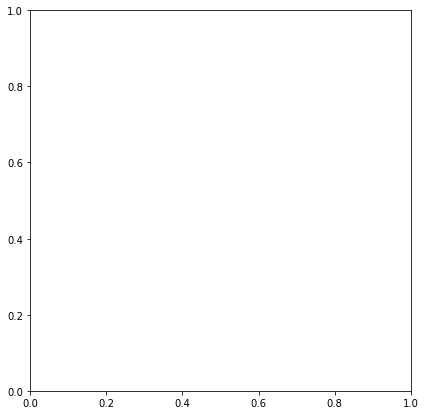

In [109]:
# Combined many FP clips and 1 TP clip into new long clips:

#Generate MANY new long clips--for each TP, select 9 random FP and randomly concatenate together (approximating 60s clip)
dest=TRAIN_AUDIO_ROOT.joinpath('gen_full_tpfp')
if dest.exists()==False:
    os.mkdir(dest)
    #D:\rfcx-species-audio-detection\train\fp_clips\FP_8_00204008d.png
tp=[png for png in TRAIN_AUDIO_ROOT.joinpath('tp_clips').glob('*.png')]
fp=[str(png) for png in TRAIN_AUDIO_ROOT.joinpath('fp_clips').glob('*.png')]
fig, ax = plt.subplots(figsize=(15, 7))
for i,p in enumerate(tp):
    tp_img=rgb2gray(io.imread(p)[:,:,0:3])
    spec=p.parts[-1].split('_')[1]
    rec=p.parts[-1].split('_')[2].split('.')[0]
    use=list(np.random.permutation(24)) # random list of possible FP to include
    use=[s for s in use if s != int(spec)] #exclude FP equal to TP 
    use=use[0:9]
    put_spec=np.random.randint(0,len(use))
    use[put_spec]=int(spec)
    new_fn='TP_%s_%s_FP' % (spec,rec)
    print('Processing %s'% new_fn)
    for j,fp_spec in enumerate(use):
        new_fn=new_fn + '_%d' % fp_spec
        if fp_spec == int(spec):
            #Load TP to this slot
            im=tp_img
        else:
            #Randomly select from available FP of desired species and load im
            fp_rec=df_fp.index[df_fp['species_id']==fp_spec]
            use_fp=fp_rec[np.random.randint(0,len(fp_rec))]
            fpfn=[fn for fn in fp if use_fp in fn][0]
            im=rgb2gray(io.imread(fpfn)[:,:,0:3])
        if j==0:
            a=im
        else:
            a=np.concatenate((a,im),axis=1)
    new_fn = new_fn + '.png'
    img_pnfn=dest.joinpath(new_fn)
    print('\tSaving to %s' % img_pnfn)
    #Plot concatenated spectogram
    plt.imshow(a,cmap='bwr')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(img_pnfn,dpi=250,pad_inches=0,bbox_inches='tight', transparent=True)
    time.sleep(0.1)
    plt.cla()

In [103]:
fp_spec=23
spec=3
use0=list(np.random.permutation(24)) # random list of possible FP to include
use1=[s for s in use0 if s != int(spec)] #exclude FP equal to TP 
use2=use1[0:9]
put_spec=np.random.randint(0,len(use2))
use3=use2
use3[put_spec]=spec
use3

[2, 17, 20, 21, 0, 9, 22, 3, 16]

In [89]:
[s for s in use0 if s != int(spec)]

[11,
 17,
 21,
 22,
 8,
 15,
 2,
 12,
 23,
 16,
 20,
 9,
 4,
 19,
 14,
 13,
 1,
 18,
 6,
 10,
 0,
 5,
 7]

In [ ]:
#Copy tp and fp into species-specific folders:
start_dirs=['tp_clips','fp_clips']
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        spec=fn.split('_')[1]
        dest = TRAIN_AUDIO_ROOT.joinpath('spec').joinpath(spec)
        if dest.exists()==False:
            os.mkdir(dest)
        #print('From %s to %s' % (png,dest))
        shutil.copy(str(png),dest)
print('Finished')

In [ ]:
#Move FP clips spectrograms from species-based folders into tp_clips data folder:
for spec in np.unique(df_fp['species_id']):
    path = TRAIN_AUDIO_ROOT.joinpath('%d' % spec)
    pngs=[png for png in path.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        tp=fn.split('_')[0]
        if tp == 'FP':
            print(png)
            shutil.move(str(png),str(TRAIN_AUDIO_ROOT.joinpath('tp_clip')))

In [ ]:
#Copy tp clips into tp_clips:
start_dirs=['tp_clips_and_full',]
for d in start_dirs:
    src=TRAIN_AUDIO_ROOT.joinpath(d)
    pngs=[png for png in src.glob('*.png')]
    for png in pngs:
        fn=png.parts[-1]
        p=fn.split('_')
        if len(p) >= 4:
            is_full=p[3] == 'full.png'
        dest = TRAIN_AUDIO_ROOT.joinpath('tp_clips').joinpath(fn)
        if not is_full:`
            print('From %s to %s' % (png,dest))
            shutil.copy(str(png),dest)
print('Finished')